In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re, json
import torch, numpy as np

import sys
sys.path.append('..')
torch.set_grad_enabled(False)

from src.utils.extract_utils import compute_function_vector #, get_mean_head_activations, compute_universal_function_vector
from src.utils.intervention_utils import fv_intervention_natural_text, function_vector_intervention
from src.utils.model_utils import load_gpt_model_and_tokenizer
from src.utils.prompt_utils import load_dataset, word_pairs_to_prompt_data, create_prompt
from src.utils.eval_utils import decode_to_vocab, sentence_eval

# To run phi-4 :3
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForVision2Seq

/home/klopez/llama_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model & tokenizer

In [2]:
# model_name = 'microsoft/phi-4'
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained(
#    model_name,
#    torch_dtype=torch.bfloat16,
#    device_map="auto",
# )
# model.config.eos_token_id = tokenizer.eos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

# model_config = {"n_heads":model.config.num_attention_heads,
#                      "n_layers":model.config.num_hidden_layers,
#                      "resid_dim":model.config.hidden_size,
#                      "name_or_path":model.config._name_or_path,
#                      "attn_hook_names":[f'model.layers.{layer}.self_attn.o_proj' for layer in range(model.config.num_hidden_layers)],
#                      "layer_hook_names":[f'model.layers.{layer}' for layer in range(model.config.num_hidden_layers)],
#                      "prepend_bos":True}

# EDIT_LAYER = 13

In [3]:
models = ['meta-llama/Meta-Llama-3-8B-Instruct', 'EleutherAI/gpt-j-6b']
model_name = models[0]
model, tokenizer, model_config = load_gpt_model_and_tokenizer(model_name)
EDIT_LAYER = 10 # 10

Loading:  meta-llama/Meta-Llama-3-8B-Instruct


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


## Load dataset and Compute task-conditioned mean activations

In [4]:
dataset_trav = load_dataset('trav_letters', seed=0)
mean_activations_trav = torch.load('/home/klopez/function_vectors/results/trav_letters/trav_letters_mean_head_activations.pt')
# mean_activations_trav = get_mean_head_activations(dataset_trav, model, model_config, tokenizer)

dataset_max = load_dataset('argmax_letters', seed=0)
mean_activations_max = torch.load('/home/klopez/function_vectors/results/argmax_letters/argmax_letters_mean_head_activations.pt')
# mean_activations_max = get_mean_head_activations(dataset_max, model, model_config, tokenizer)

## Compute function vector (FV)

In [5]:
# indirect_effect_trav= torch.load('/home/klopez/function_vectors/results/traverse2/traverse2_indirect_effect.pt')
# indirect_effect_max = torch.load('/home/klopez/function_vectors/results/argmax3/argmax3_indirect_effect.pt')

indirect_effect_trav = torch.load('/home/klopez/function_vectors/results/trav_letters/trav_letters_indirect_effect.pt')
indirect_effect_max = torch.load('/home/klopez/function_vectors/results/argmax_letters/argmax_letters_indirect_effect.pt')

FV_trav, top_heads_trav = compute_function_vector(mean_activations_trav, indirect_effect_trav, model, model_config, n_top_heads=20)
FV_max, top_heads_max = compute_function_vector(mean_activations_max, indirect_effect_max, model, model_config, n_top_heads=20)

FV_unnorm = torch.add(FV_max, FV_trav)
FV = FV_unnorm # torch.nn.functional.normalize(FV_unnorm)

## Prompt Creation - ICL, Shuffled-Label, Zero-Shot, and Natural Text (traverse)

In [ ]:
# # Sample ICL example pairs, and a test word (traverse)
# dataset1 = load_dataset('traverse2')
# train_data1 = dataset1['train'][:5]

# test_pair1 = {
#     "input": "path: lobby-20-69",
#     "output": "69"
#   }

# prompt_data = word_pairs_to_prompt_data(train_data1, query_target_pair=test_pair1, prepend_bos_token=True)
# sentence = create_prompt(prompt_data)
# print("ICL prompt:\n", repr(sentence), '\n\n')

# shuffled_prompt_data = word_pairs_to_prompt_data(train_data1, query_target_pair=test_pair1, prepend_bos_token=True, shuffle_labels=True)
# shuffled_sentence = create_prompt(shuffled_prompt_data)
# print("Shuffled ICL Prompt:\n", repr(shuffled_sentence), '\n\n')

# zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair1, prepend_bos_token=True, shuffle_labels=True)
# zeroshot_sentence = create_prompt(zeroshot_prompt_data)
# print("Zero-Shot Prompt:\n", repr(zeroshot_sentence))

# # ICL
# # Check model's ICL answer
# clean_logits = sentence_eval(sentence, [test_pair1['output']], model, tokenizer, compute_nll=False)

# print("Input Graph:", repr(sentence), '\n')
# print(f"Input Query: {repr(test_pair1['input'])}, Target: {repr(test_pair1['output'])}\n")
# print("ICL Prompt Top K Answer Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')

# # CORRUPTED FEW-SHOT
# # Perform an intervention on the shuffled setting
# clean_logits, interv_logits = function_vector_intervention(shuffled_sentence, [test_pair1['output']], EDIT_LAYER, FV_trav, model, model_config, tokenizer)

# print("Input Sentence:", repr(shuffled_sentence), '\n')
# print(f"Input Query: {repr(test_pair1['input'])}, Target: {repr(test_pair1['output'])}\n")
# print("Few-Shot-Shuffled Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')
# print("Shuffled Prompt+FV Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=10))

# # NO-SHOT
# # Intervention on the zero-shot prompt
# clean_logits, interv_logits, hidden_states = function_vector_intervention(zeroshot_sentence, [test_pair1['output']], EDIT_LAYER, FV_trav, model, model_config, tokenizer)

# print("Input Sentence:", repr(zeroshot_sentence), '\n')
# print(f"Input Query: {repr(test_pair1['input'])}, Target: {repr(test_pair1['output'])}\n")
# print("Zero-Shot Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')
# print("Zero-Shot+FV Vocab Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=10))

ICL prompt:
 '<|endoftext|>Q: path: lobby-61-70\nA: 70\n\nQ: path: lobby-74-100-44\nA: 44\n\nQ: path: lobby-51-6-65\nA: 65\n\nQ: path: lobby-35-12\nA: 12\n\nQ: path: lobby-2-18\nA: 18\n\nQ: path: lobby-20-69\nA:' 


Shuffled ICL Prompt:
 '<|endoftext|>Q: path: lobby-61-70\nA: 12\n\nQ: path: lobby-74-100-44\nA: 70\n\nQ: path: lobby-51-6-65\nA: 44\n\nQ: path: lobby-35-12\nA: 18\n\nQ: path: lobby-2-18\nA: 65\n\nQ: path: lobby-20-69\nA:' 


Zero-Shot Prompt:
 '<|endoftext|>Q: path: lobby-20-69\nA:'
Input Graph: '<|endoftext|>Q: path: lobby-61-70\nA: 70\n\nQ: path: lobby-74-100-44\nA: 44\n\nQ: path: lobby-51-6-65\nA: 65\n\nQ: path: lobby-35-12\nA: 12\n\nQ: path: lobby-2-18\nA: 18\n\nQ: path: lobby-20-69\nA:' 

Input Query: 'path: lobby-20-69', Target: '69'

ICL Prompt Top K Answer Probs:
 [(' ', 0.99707), (' \n\n', 0.00024), (' -', 0.00013), ('?', 9e-05), (' null', 8e-05), (' none', 8e-05), (' None', 7e-05), (' <', 7e-05), (' \n', 6e-05), (' |', 6e-05)] 

Input Sentence: '<|endoftext|>Q: pa

ValueError: only one element tensors can be converted to Python scalars

## Prompt Creation - ICL, Shuffled-Label, Zero-Shot, and Natural Text (argmax)

In [ ]:
# # Sample ICL example pairs, and a test word (comp)
# dataset2 = load_dataset('argmax3')
# train_data2 = dataset2['train'][:5]

# test_pair2 = {
#     "input": "rewards=[9:46 vs 66:91]",
#     "output": "66"
#   }

# prompt_data = word_pairs_to_prompt_data(train_data2, query_target_pair=test_pair2, prepend_bos_token=True)
# sentence = create_prompt(prompt_data)
# print("ICL prompt:\n", repr(sentence), '\n\n')

# shuffled_prompt_data = word_pairs_to_prompt_data(train_data2, query_target_pair=test_pair2, prepend_bos_token=True, shuffle_labels=True)
# shuffled_sentence = create_prompt(shuffled_prompt_data)
# print("Shuffled ICL Prompt:\n", repr(shuffled_sentence), '\n\n')

# zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair2, prepend_bos_token=True, shuffle_labels=True)
# zeroshot_sentence = create_prompt(zeroshot_prompt_data)
# print("Zero-Shot Prompt:\n", repr(zeroshot_sentence))

# # ICL
# # Check model's ICL answer
# clean_logits = sentence_eval(sentence, [test_pair2['output']], model, tokenizer, compute_nll=False)

# print("Input Graph:", repr(sentence), '\n')
# print(f"Input Query: {repr(test_pair2['input'])}, Target: {repr(test_pair2['output'])}\n")
# print("ICL Prompt Top K Answer Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')

# # CORRUPTED FEW-SHOT
# # Perform an intervention on the shuffled setting
# clean_logits, interv_logits = function_vector_intervention(shuffled_sentence, [test_pair2['output']], EDIT_LAYER, FV_max, model, model_config, tokenizer)

# print("Input Sentence:", repr(shuffled_sentence), '\n')
# print(f"Input Query: {repr(test_pair2['input'])}, Target: {repr(test_pair2['output'])}\n")
# print("Few-Shot-Shuffled Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')
# print("Shuffled Prompt+FV Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=10))

# # NO-SHOT
# # Intervention on the zero-shot prompt
# clean_logits, interv_logits = function_vector_intervention(zeroshot_sentence, [test_pair2['output']], EDIT_LAYER, FV_max, model, model_config, tokenizer)

# print("Input Sentence:", repr(zeroshot_sentence), '\n')
# print(f"Input Query: {repr(test_pair2['input'])}, Target: {repr(test_pair2['output'])}\n")
# print("Zero-Shot Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=10), '\n')
# print("Zero-Shot+FV Vocab Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=10))

ICL prompt:
 '<|endoftext|>Q: rewards=[7:66 vs 14:97]\nA: 14\n\nQ: rewards=[23:69 vs 20:57]\nA: 23\n\nQ: rewards=[57:74 vs 73:45]\nA: 57\n\nQ: rewards=[7:12 vs 35:99]\nA: 35\n\nQ: rewards=[48:31 vs 19:86]\nA: 19\n\nQ: rewards=[9:46 vs 66:91]\nA:' 


Shuffled ICL Prompt:
 '<|endoftext|>Q: rewards=[7:66 vs 14:97]\nA: 35\n\nQ: rewards=[23:69 vs 20:57]\nA: 23\n\nQ: rewards=[57:74 vs 73:45]\nA: 19\n\nQ: rewards=[7:12 vs 35:99]\nA: 57\n\nQ: rewards=[48:31 vs 19:86]\nA: 14\n\nQ: rewards=[9:46 vs 66:91]\nA:' 


Zero-Shot Prompt:
 '<|endoftext|>Q: rewards=[9:46 vs 66:91]\nA:'
Input Graph: '<|endoftext|>Q: rewards=[7:66 vs 14:97]\nA: 14\n\nQ: rewards=[23:69 vs 20:57]\nA: 23\n\nQ: rewards=[57:74 vs 73:45]\nA: 57\n\nQ: rewards=[7:12 vs 35:99]\nA: 35\n\nQ: rewards=[48:31 vs 19:86]\nA: 19\n\nQ: rewards=[9:46 vs 66:91]\nA:' 

Input Query: 'rewards=[9:46 vs 66:91]', Target: '66'

ICL Prompt Top K Answer Probs:
 [(' ', 0.99882), ('...', 0.00011), ('...\n\n', 8e-05), (' \n\n', 7e-05), (' |', 5e-05), (' 

## Evaluation

## Prompt Creation - ICL, Shuffled-Label, Zero-Shot, and Natural Text (combined)

In [6]:
# Sample ICL example pairs, and a test word (comp)
dataset = load_dataset('composite_letters')
train_data = dataset['train'][:10]

test_pairs = [
  {
    "input": "path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7].",
    "output": "R"
  },
{
    "input": "path1: K-X-I-J. path1-rewards=[M:69 vs J:72]. path2: B-Q-H. path2-rewards=[M:19 vs H:88].",
    "output": "H"
  },
{
    "input": "path1: T-G-I. path1-rewards=[I:40 vs B:34]. path2: O-Z-W-P. path2-rewards=[B:55 vs P:58].",
    "output": "P"
  },
{
    "input": "path1: N-K. path1-rewards=[F:86 vs K:96]. path2: G-O-P-D-U. path2-rewards=[F:86 vs U:99].",
    "output": "U"
  },
{
    "input": "path1: G-F-A-H. path1-rewards=[B:97 vs H:59]. path2: D-E-Q-C-W. path2-rewards=[B:94 vs W:94].",
    "output": "W"
  },
{
    "input": "path1: B-A-I. path1-rewards=[I:58 vs M:71]. path2: S-F-C-N-J. path2-rewards=[M:75 vs J:41].",
    "output": "I"
  },
{
    "input": "path1: B-Q-P-U-X. path1-rewards=[G:39 vs X:1]. path2: A-W-O-C. path2-rewards=[C:23 vs G:64].",
    "output": "C"
  },
{
    "input": "path1: C-Q-Y. path1-rewards=[Y:10 vs Z:4]. path2: M-L-D. path2-rewards=[D:91 vs Z:21].",
    "output": "D"
  },
{
    "input": "path1: A-B-D. path1-rewards=[W:12 vs D:11]. path2: H-Z-O-V. path2-rewards=[W:36 vs V:97].",
    "output": "V"
  },
{
    "input": "path1: R-I-U-F-Z. path1-rewards=[Q:36 vs Z:13]. path2: V-J-O. path2-rewards=[O:45 vs Q:60].",
    "output": "O"
  },
{
    "input": "path1: W-M-I-J. path1-rewards=[J:59 vs G:45]. path2: D-E-S-O-B. path2-rewards=[G:5 vs B:39].",
    "output": "J"
  },
{
    "input": "path1: V-J-S-A. path1-rewards=[A:43 vs T:85]. path2: H-W-F-B. path2-rewards=[T:2 vs B:64].",
    "output": "B"
  },
{
    "input": "path1: T-A. path1-rewards=[A:21 vs U:1]. path2: C-Y. path2-rewards=[U:62 vs Y:57].",
    "output": "Y"
  },
{
    "input": "path1: S-C. path1-rewards=[C:5 vs I:36]. path2: J-L-D-X. path2-rewards=[I:67 vs X:57].",
    "output": "X"
  },
{
    "input": "path1: N-J-K-L. path1-rewards=[L:57 vs V:33]. path2: R-E. path2-rewards=[V:44 vs E:75].",
    "output": "E"
  },
{
    "input": "path1: F-Q-A. path1-rewards=[I:29 vs A:24]. path2: E-J. path2-rewards=[J:12 vs I:62].",
    "output": "A"
  },
{
    "input": "path1: X-U-L-D. path1-rewards=[D:2 vs F:28]. path2: T-W-H-P-K. path2-rewards=[F:93 vs K:68].",
    "output": "K"
  },
{
    "input": "path1: H-A-D-W-S. path1-rewards=[S:55 vs R:2]. path2: Y-Q-J. path2-rewards=[J:14 vs R:24].",
    "output": "S"
  },
{
    "input": "path1: E-K-H-A-X. path1-rewards=[X:39 vs W:62]. path2: J-T-G-N. path2-rewards=[W:57 vs N:93].",
    "output": "N"
  }, {
    "input": "path1: K-L-D-Z. path1-rewards=[Z:31 vs H:24]. path2: P-R-N-M. path2-rewards=[M:60 vs H:48].",
    "output": "M"
  }
]

test_pair = test_pairs[0]

prompt_data = word_pairs_to_prompt_data(train_data, query_target_pair=test_pair, prepend_bos_token=True)
sentence = create_prompt(prompt_data)
print("ICL prompt:\n", repr(sentence), '\n\n')

shuffled_prompt_data = word_pairs_to_prompt_data(train_data, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
# dataset_shuf = load_dataset('composite_shuffle')
# train_data_shuf = dataset_shuf['train'][:5]
# shuffled_prompt_data = word_pairs_to_prompt_data(train_data_shuf, query_target_pair=test_pair, prepend_bos_token=True)
shuffled_sentence = create_prompt(shuffled_prompt_data)
print("Shuffled ICL Prompt:\n", repr(shuffled_sentence), '\n\n')

zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
zeroshot_sentence = create_prompt(zeroshot_prompt_data)
print("Zero-Shot Prompt:\n", repr(zeroshot_sentence))

ICL prompt:
 '<|endoftext|>Q: path1: X-U-L-D. path1-rewards=[D:2 vs F:28]. path2: T-W-H-P-K. path2-rewards=[F:93 vs K:68].\nA: K\n\nQ: path1: A-U-W-C-H. path1-rewards=[H:32 vs L:100]. path2: F-J. path2-rewards=[J:6 vs L:51].\nA: H\n\nQ: path1: E-A-S-Z-D. path1-rewards=[C:80 vs D:59]. path2: R-I-G-F-U. path2-rewards=[C:31 vs U:12].\nA: D\n\nQ: path1: W-Y. path1-rewards=[Y:59 vs D:64]. path2: E-O-L-V. path2-rewards=[V:77 vs D:78].\nA: V\n\nQ: path1: X-I-Y-V-Z. path1-rewards=[H:96 vs Z:38]. path2: N-W-B-A-S. path2-rewards=[H:45 vs S:25].\nA: Z\n\nQ: path1: E-R. path1-rewards=[Z:7 vs R:94]. path2: A-P. path2-rewards=[P:50 vs Z:78].\nA: R\n\nQ: path1: T-A. path1-rewards=[A:21 vs U:1]. path2: C-Y. path2-rewards=[U:62 vs Y:57].\nA: Y\n\nQ: path1: K-L. path1-rewards=[G:77 vs L:2]. path2: D-O-C. path2-rewards=[G:10 vs C:67].\nA: C\n\nQ: path1: F-P. path1-rewards=[P:59 vs N:89]. path2: Q-O-K-C. path2-rewards=[C:57 vs N:35].\nA: P\n\nQ: path1: J-D-M. path1-rewards=[M:30 vs R:92]. path2: B-L-P. pa

### Clean ICL Prompt

In [7]:
# Check model's ICL answer
clean_logits, hidden_states_icl, inputs_icl = sentence_eval(sentence, [test_pair['output']], model, tokenizer, compute_nll=False) # , generate_str=True)

print("Input Graph:", repr(sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("ICL Prompt Top K Answer Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')

# print response
predicted_token_ids = []
for score_tensor in clean_logits:
    # Apply argmax to get the most probable token ID for each generated step
    predicted_id = torch.argmax(score_tensor, dim=-1).item()
    predicted_token_ids.append(predicted_id)

print(f"Predicted token IDs from logits: {predicted_token_ids}")
print(tokenizer.decode(predicted_token_ids))

Input Graph: '<|endoftext|>Q: path1: X-U-L-D. path1-rewards=[D:2 vs F:28]. path2: T-W-H-P-K. path2-rewards=[F:93 vs K:68].\nA: K\n\nQ: path1: A-U-W-C-H. path1-rewards=[H:32 vs L:100]. path2: F-J. path2-rewards=[J:6 vs L:51].\nA: H\n\nQ: path1: E-A-S-Z-D. path1-rewards=[C:80 vs D:59]. path2: R-I-G-F-U. path2-rewards=[C:31 vs U:12].\nA: D\n\nQ: path1: W-Y. path1-rewards=[Y:59 vs D:64]. path2: E-O-L-V. path2-rewards=[V:77 vs D:78].\nA: V\n\nQ: path1: X-I-Y-V-Z. path1-rewards=[H:96 vs Z:38]. path2: N-W-B-A-S. path2-rewards=[H:45 vs S:25].\nA: Z\n\nQ: path1: E-R. path1-rewards=[Z:7 vs R:94]. path2: A-P. path2-rewards=[P:50 vs Z:78].\nA: R\n\nQ: path1: T-A. path1-rewards=[A:21 vs U:1]. path2: C-Y. path2-rewards=[U:62 vs Y:57].\nA: Y\n\nQ: path1: K-L. path1-rewards=[G:77 vs L:2]. path2: D-O-C. path2-rewards=[G:10 vs C:67].\nA: C\n\nQ: path1: F-P. path1-rewards=[P:59 vs N:89]. path2: Q-O-K-C. path2-rewards=[C:57 vs N:35].\nA: P\n\nQ: path1: J-D-M. path1-rewards=[M:30 vs R:92]. path2: B-L-P. pa

### Corrupted ICL Prompt

In [26]:
# Perform an intervention on the shuffled setting
(clean_logits, interv_logits), inputs_cicl, hidden_states_cicl, hidden_states_cicl_fv = function_vector_intervention(shuffled_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

# print response
predicted_token_ids = []
for score_tensor in clean_logits:
    # Apply argmax to get the most probable token ID for each generated step
    predicted_id = torch.argmax(score_tensor, dim=-1).item()
    predicted_token_ids.append(predicted_id)

print(f"Predicted token IDs from logits: {predicted_token_ids}")
print(tokenizer.decode(predicted_token_ids), '\n')

num_prompts=5
print("Input Sentence:", repr(shuffled_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print(f"Few-Shot-Shuffled Prompt Top {num_prompts} Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')
print(f"Shuffled Prompt+FV Top {num_prompts} Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

Predicted token IDs from logits: [432]
 R 

Input Sentence: '<|endoftext|>Q: path1: X-U-L-D. path1-rewards=[D:2 vs F:28]. path2: T-W-H-P-K. path2-rewards=[F:93 vs K:68].\nA: V\n\nQ: path1: A-U-W-C-H. path1-rewards=[H:32 vs L:100]. path2: F-J. path2-rewards=[J:6 vs L:51].\nA: D\n\nQ: path1: E-A-S-Z-D. path1-rewards=[C:80 vs D:59]. path2: R-I-G-F-U. path2-rewards=[C:31 vs U:12].\nA: R\n\nQ: path1: W-Y. path1-rewards=[Y:59 vs D:64]. path2: E-O-L-V. path2-rewards=[V:77 vs D:78].\nA: H\n\nQ: path1: X-I-Y-V-Z. path1-rewards=[H:96 vs Z:38]. path2: N-W-B-A-S. path2-rewards=[H:45 vs S:25].\nA: C\n\nQ: path1: E-R. path1-rewards=[Z:7 vs R:94]. path2: A-P. path2-rewards=[P:50 vs Z:78].\nA: K\n\nQ: path1: T-A. path1-rewards=[A:21 vs U:1]. path2: C-Y. path2-rewards=[U:62 vs Y:57].\nA: P\n\nQ: path1: K-L. path1-rewards=[G:77 vs L:2]. path2: D-O-C. path2-rewards=[G:10 vs C:67].\nA: Y\n\nQ: path1: F-P. path1-rewards=[P:59 vs N:89]. path2: Q-O-K-C. path2-rewards=[C:57 vs N:35].\nA: P\n\nQ: path1: J-D-M.

### Zero-Shot Prompt

In [27]:
# Intervention on the zero-shot prompt
(clean_logits, interv_logits), inputs_ns, hidden_states_ns, hidden_states_ns_fv = function_vector_intervention(zeroshot_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

num_prompts=5
print("Input Sentence:", repr(zeroshot_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print(f"Zero-Shot Top {num_prompts} Probs:\n", decode_to_vocab(clean_logits, tokenizer, num_prompts), '\n')
print(f"Zero-Shot+FV Vocab Top {num_prompts} Probs:\n", decode_to_vocab(interv_logits, tokenizer, num_prompts))

Input Sentence: '<|endoftext|>Q: path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7].\nA:' 

Input Query: 'path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7].', Target: 'R'

Zero-Shot Top 5 Probs:
 [(' path', 0.15796), (' The', 0.09365), (' I', 0.05018), (' What', 0.0298), (' This', 0.02668)] 

Zero-Shot+FV Vocab Top 5 Probs:
 [(' V', 0.69442), (' O', 0.15796), (' R', 0.07661), (' S', 0.02972), (' H', 0.00773)]


### Natural Text Prompt

In [10]:
sentence = f"Given two graphs \"{test_pair['input']}\" the longest path is"
co, io = fv_intervention_natural_text(sentence, EDIT_LAYER, FV, model, model_config, tokenizer, max_new_tokens=10)


print("Input Sentence: ", repr(sentence))
print("LLAMA-3-8B:" , repr(tokenizer.decode(co.squeeze())))
print("LLAMA-3-8B+FV:", repr(tokenizer.decode(io.squeeze())), '\n')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input Sentence:  'Given two graphs "path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7]." the longest path is'
LLAMA-3-8B: '<|begin_of_text|>Given two graphs "path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7]." the longest path is "path1: A-S-R" with a'
LLAMA-3-8B+FV: '<|begin_of_text|>Given two graphs "path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7]." the longest path is R R R R R R R R R R' 



In [ ]:
# RUN TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn as nn

# clean tokens
detok_icl = tokenizer.convert_ids_to_tokens(inputs_icl["input_ids"][0])
detok_cicl = tokenizer.convert_ids_to_tokens(inputs_cicl["input_ids"][0])
detok_ns = tokenizer.convert_ids_to_tokens(inputs_ns["input_ids"][0])

tokens_icl = [t.lstrip("Ġ") for t in detok_icl]
tokens_cicl = [t.lstrip("Ġ") for t in detok_cicl]
tokens_ns = [t.lstrip("Ġ") for t in detok_ns]

# find all layers
all_layers_icl = torch.stack(hidden_states_icl, dim=0)[:, 0, :, :]  
num_layers_icl, seq_len_icl, hidden_size_icl = all_layers_icl.shape

all_layers_cicl = torch.stack(hidden_states_cicl, dim=0)[:, 0, :, :]  
num_layers_cicl, seq_len_cicl, hidden_size_cicl = all_layers_cicl.shape

all_layers_ns = torch.stack(hidden_states_ns, dim=0)[:, 0, :, :]  
num_layers_ns, seq_len_ns, hidden_size_ns = all_layers_ns.shape

all_layers_cicl_fv = torch.stack(hidden_states_cicl_fv, dim=0)[:, 0, :, :]  
num_layers_cicl_fv, seq_len_cicl_fv, hidden_size_cicl_fv = all_layers_cicl_fv.shape

all_layers_ns = torch.stack(hidden_states_ns, dim=0)[:, 0, :, :]  
num_layers_ns, seq_len_ns, hidden_size_ns = all_layers_ns.shape

all_layers_ns_fv = torch.stack(hidden_states_ns_fv, dim=0)[:, 0, :, :]  
num_layers_ns_fv, seq_len_ns_fv, hidden_size_ns_fv = all_layers_ns_fv.shape

# find indices of nodes
nodes = ["R", "V", "H"]
node_indices_icl = [i for i, tk in enumerate(tokens_icl) if tk in nodes][-4:]
node_labels_icl = [tokens_icl[i] for i in node_indices_icl]
n_nodes_icl = len(node_indices_icl)

node_indices_cicl = [i for i, tk in enumerate(tokens_cicl) if tk in nodes][-4:]
node_labels_cicl = [tokens_cicl[i] for i in node_indices_cicl]
n_nodes_cicl = len(node_indices_cicl)

node_indices_cicl_fv = [i for i, tk in enumerate(tokens_cicl) if tk in nodes][-4:]
node_labels_cicl_fv = [tokens_cicl[i] for i in node_indices_cicl_fv]
n_nodes_cicl_fv = len(node_indices_cicl_fv)

node_indices_ns = [i for i, tk in enumerate(tokens_ns) if tk in nodes]
node_labels_ns = [tokens_ns[i] for i in node_indices_ns]
n_nodes_ns = len(node_indices_ns)

node_indices_ns_fv = [i for i, tk in enumerate(tokens_ns) if tk in nodes]
node_labels_ns_fv = [tokens_ns[i] for i in node_indices_ns_fv]
n_nodes_ns_fv = len(node_indices_ns_fv)

# extract embeddings icl
selected_icl = all_layers_icl[:, node_indices_icl, :]
selected_cicl = all_layers_cicl[:, node_indices_cicl, :]
selected_ns = all_layers_ns[:, node_indices_ns, :]
selected_cicl_fv = all_layers_cicl_fv[:, node_indices_cicl_fv, :]
selected_ns_fv = all_layers_ns_fv[:, node_indices_ns_fv, :]

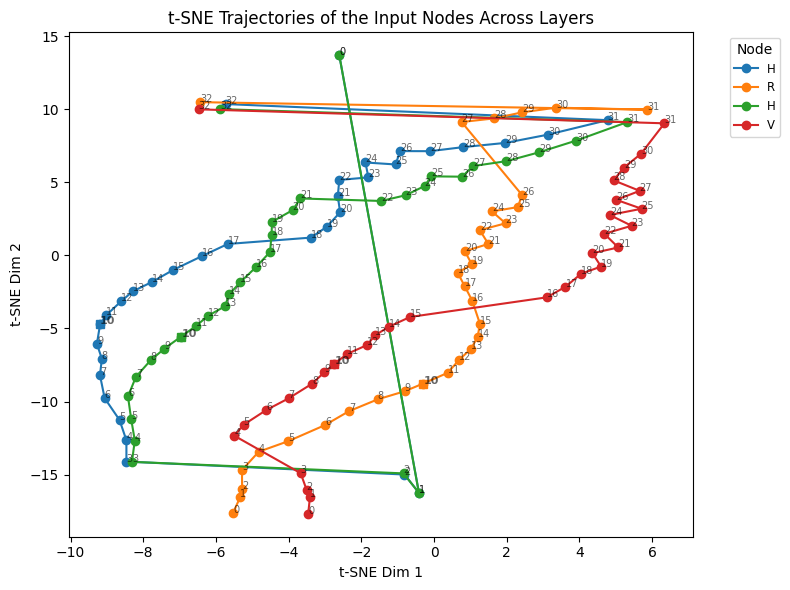

In [23]:
# plot tsne ICL 
flat_icl = selected_icl.reshape(num_layers_icl * n_nodes_icl, hidden_size_icl).cpu().numpy()

rms = np.sqrt(np.mean(flat_icl**2, axis=1, keepdims=True))
epsilon = 1e-8
flat_icl_rms_norm = flat_icl / (rms + epsilon)

tsne_icl = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42
)

flat_2d_icl = tsne_icl.fit_transform(flat_icl_rms_norm)
traj_icl = flat_2d_icl.reshape(num_layers_icl, n_nodes_icl, 2)

plt.figure(figsize=(8, 6))
for j, lbl in enumerate(node_labels_icl):
    x = traj_icl[:, j, 0]
    y = traj_icl[:, j, 1]
    plt.plot(x, y, marker="o", label=lbl)
    plt.plot(x[10], y[10], marker="s", color=plt.gca().lines[-1].get_color(), linestyle='None')
    for layer in range(num_layers_icl):
        if layer == 10:
            plt.text(x[layer], y[layer], str(layer), fontsize=8, fontweight="bold", alpha=0.6)
        else:
            plt.text(x[layer], y[layer], str(layer), fontsize=7, alpha=0.6)

plt.title("t‑SNE Trajectories of the Input Nodes Across Layers")
plt.xlabel("t‑SNE Dim 1")
plt.ylabel("t‑SNE Dim 2")
plt.legend(title="Node", bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()

plt.savefig("node_evolution_all_layers_tsne_icl.pdf", format="pdf", dpi=300)
plt.show()

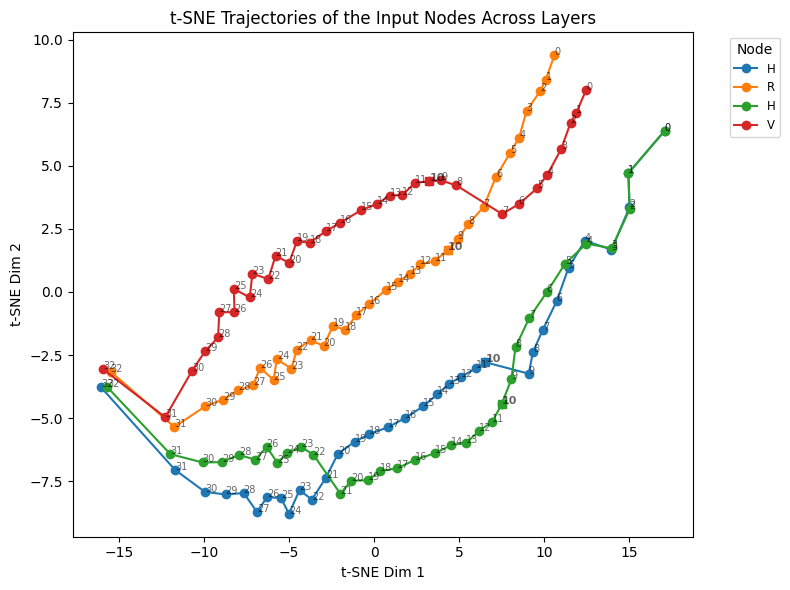

In [24]:
# plot tsne CICL 
flat_cicl = selected_cicl.reshape(num_layers_cicl * n_nodes_cicl, hidden_size_cicl).cpu().numpy()

rms = np.sqrt(np.mean(flat_cicl**2, axis=1, keepdims=True))
epsilon = 1e-8
flat_cicl_rms_norm = flat_cicl / (rms + epsilon)

tsne_cicl = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42
)

flat_2d_cicl = tsne_cicl.fit_transform(flat_cicl_rms_norm)
traj_cicl = flat_2d_cicl.reshape(num_layers_cicl, n_nodes_cicl, 2)

plt.figure(figsize=(8, 6))
for j, lbl in enumerate(node_labels_cicl):
    x = traj_cicl[:, j, 0]
    y = traj_cicl[:, j, 1]
    plt.plot(x, y, marker="o", label=lbl)
    plt.plot(x[10], y[10], marker="s", color=plt.gca().lines[-1].get_color(), linestyle='None')
    for layer in range(num_layers_cicl):
        if layer == 10:
            plt.text(x[layer], y[layer], str(layer), fontsize=8, fontweight="bold", alpha=0.6)
        else:
            plt.text(x[layer], y[layer], str(layer), fontsize=7, alpha=0.6)

plt.title("t‑SNE Trajectories of the Input Nodes Across Layers")
plt.xlabel("t‑SNE Dim 1")
plt.ylabel("t‑SNE Dim 2")
plt.legend(title="Node", bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()

plt.savefig("node_evolution_all_layers_tsne_cicl.pdf", format="pdf", dpi=300)
plt.show()

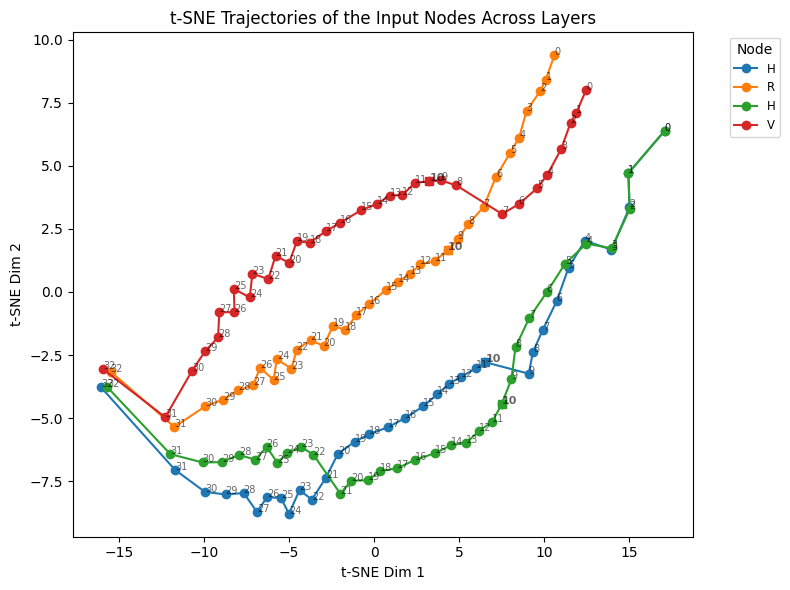

In [29]:
# plot tsne CICL+FV
flat_cicl_fv = selected_cicl_fv.reshape(num_layers_cicl_fv * n_nodes_cicl_fv, hidden_size_cicl_fv).cpu().numpy()

rms = np.sqrt(np.mean(flat_cicl_fv**2, axis=1, keepdims=True))
epsilon = 1e-8
flat_cicl_rms_norm_fv = flat_cicl_fv / (rms + epsilon)

tsne_cicl_fv = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42
)

flat_2d_cicl_fv = tsne_cicl_fv.fit_transform(flat_cicl_rms_norm_fv)
traj_cicl_fv = flat_2d_cicl_fv.reshape(num_layers_cicl_fv, n_nodes_cicl_fv, 2)

plt.figure(figsize=(8, 6))
for j, lbl in enumerate(node_labels_cicl_fv):
    x = traj_cicl_fv[:, j, 0]
    y = traj_cicl_fv[:, j, 1]
    plt.plot(x, y, marker="o", label=lbl)
    plt.plot(x[10], y[10], marker="s", color=plt.gca().lines[-1].get_color(), linestyle='None')
    for layer in range(num_layers_cicl_fv):
        if layer == 10:
            plt.text(x[layer], y[layer], str(layer), fontsize=8, fontweight="bold", alpha=0.6)
        else:
            plt.text(x[layer], y[layer], str(layer), fontsize=7, alpha=0.6)

plt.title("t‑SNE Trajectories of the Input Nodes Across Layers")
plt.xlabel("t‑SNE Dim 1")
plt.ylabel("t‑SNE Dim 2")
plt.legend(title="Node", bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()

plt.savefig("node_evolution_all_layers_tsne_cicl_fv.pdf", format="pdf", dpi=300)
plt.show()

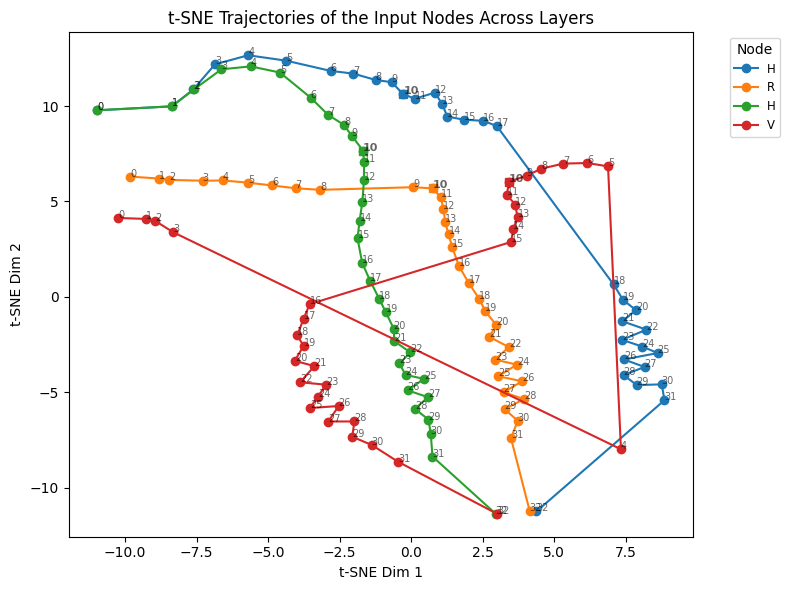

In [19]:
# plot tsne NS
flat_ns = selected_ns.reshape(num_layers_ns * n_nodes_ns, hidden_size_ns).cpu().numpy()

rms = np.sqrt(np.mean(flat_ns**2, axis=1, keepdims=True))
epsilon = 1e-8
flat_ns_rms_norm = flat_ns / (rms + epsilon)

tsne_ns = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42
)

flat_2d_ns = tsne_ns.fit_transform(flat_ns_rms_norm)
traj_ns = flat_2d_ns.reshape(num_layers_ns, n_nodes_ns, 2)

plt.figure(figsize=(8, 6))
for j, lbl in enumerate(node_labels_ns):
    x = traj_ns[:, j, 0]
    y = traj_ns[:, j, 1]
    plt.plot(x, y, marker="o", label=lbl)
    plt.plot(x[10], y[10], marker="s", color=plt.gca().lines[-1].get_color(), linestyle='None')
    for layer in range(num_layers_ns):
        if layer == 10:
            plt.text(x[layer], y[layer], str(layer), fontsize=8, fontweight="bold", alpha=0.6)
        else:
            plt.text(x[layer], y[layer], str(layer), fontsize=7, alpha=0.6)

plt.title("t‑SNE Trajectories of the Input Nodes Across Layers")
plt.xlabel("t‑SNE Dim 1")
plt.ylabel("t‑SNE Dim 2")
plt.legend(title="Node", bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()

plt.savefig("node_evolution_all_layers_tsne_ns.pdf", format="pdf", dpi=300)
plt.show()

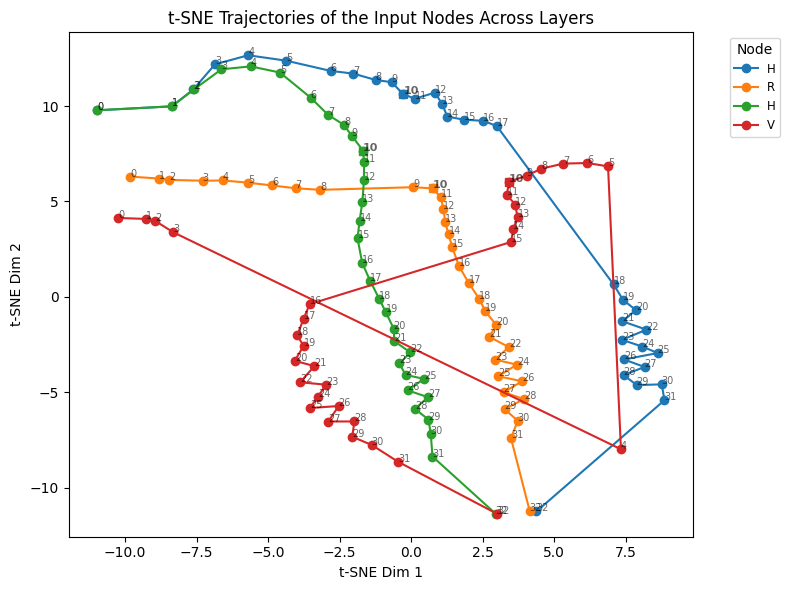

In [30]:
# plot tsne NS
flat_ns_fv = selected_ns_fv.reshape(num_layers_ns_fv * n_nodes_ns_fv, hidden_size_ns_fv).cpu().numpy()

rms = np.sqrt(np.mean(flat_ns_fv**2, axis=1, keepdims=True))
epsilon = 1e-8
flat_ns_rms_norm_fv = flat_ns_fv / (rms + epsilon)

tsne_ns_fv = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42
)

flat_2d_ns_fv = tsne_ns_fv.fit_transform(flat_ns_rms_norm_fv)
traj_ns_fv = flat_2d_ns_fv.reshape(num_layers_ns_fv, n_nodes_ns_fv, 2)

plt.figure(figsize=(8, 6))
for j, lbl in enumerate(node_labels_ns_fv):
    x = traj_ns_fv[:, j, 0]
    y = traj_ns_fv[:, j, 1]
    plt.plot(x, y, marker="o", label=lbl)
    plt.plot(x[10], y[10], marker="s", color=plt.gca().lines[-1].get_color(), linestyle='None')
    for layer in range(num_layers_ns_fv):
        if layer == 10:
            plt.text(x[layer], y[layer], str(layer), fontsize=8, fontweight="bold", alpha=0.6)
        else:
            plt.text(x[layer], y[layer], str(layer), fontsize=7, alpha=0.6)

plt.title("t‑SNE Trajectories of the Input Nodes Across Layers")
plt.xlabel("t‑SNE Dim 1")
plt.ylabel("t‑SNE Dim 2")
plt.legend(title="Node", bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout()

plt.savefig("node_evolution_all_layers_tsne_ns_fv.pdf", format="pdf", dpi=300)
plt.show()

In [8]:
# Sample ICL example pairs, and a test word (comp)
dataset = load_dataset('composite_letters')
train_data = dataset['train'][:10]

test_pairs = [
  {
    "input": "path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7].",
    "output": "R"
  },
{
    "input": "path1: K-X-I-J. path1-rewards=[M:69 vs J:72]. path2: B-Q-H. path2-rewards=[M:19 vs H:88].",
    "output": "H"
  },
{
    "input": "path1: T-G-I. path1-rewards=[I:40 vs B:34]. path2: O-Z-W-P. path2-rewards=[B:55 vs P:58].",
    "output": "P"
  },
{
    "input": "path1: N-K. path1-rewards=[F:86 vs K:96]. path2: G-O-P-D-U. path2-rewards=[F:86 vs U:99].",
    "output": "U"
  },
{
    "input": "path1: G-F-A-H. path1-rewards=[B:97 vs H:59]. path2: D-E-Q-C-W. path2-rewards=[B:94 vs W:94].",
    "output": "W"
  },
{
    "input": "path1: B-A-I. path1-rewards=[I:58 vs M:71]. path2: S-F-C-N-J. path2-rewards=[M:75 vs J:41].",
    "output": "I"
  },
{
    "input": "path1: B-Q-P-U-X. path1-rewards=[G:39 vs X:1]. path2: A-W-O-C. path2-rewards=[C:23 vs G:64].",
    "output": "C"
  },
{
    "input": "path1: C-Q-Y. path1-rewards=[Y:10 vs Z:4]. path2: M-L-D. path2-rewards=[D:91 vs Z:21].",
    "output": "D"
  },
{
    "input": "path1: A-B-D. path1-rewards=[W:12 vs D:11]. path2: H-Z-O-V. path2-rewards=[W:36 vs V:97].",
    "output": "V"
  },
{
    "input": "path1: R-I-U-F-Z. path1-rewards=[Q:36 vs Z:13]. path2: V-J-O. path2-rewards=[O:45 vs Q:60].",
    "output": "O"
  },
{
    "input": "path1: W-M-I-J. path1-rewards=[J:59 vs G:45]. path2: D-E-S-O-B. path2-rewards=[G:5 vs B:39].",
    "output": "J"
  },
{
    "input": "path1: V-J-S-A. path1-rewards=[A:43 vs T:85]. path2: H-W-F-B. path2-rewards=[T:2 vs B:64].",
    "output": "B"
  },
{
    "input": "path1: T-A. path1-rewards=[A:21 vs U:1]. path2: C-Y. path2-rewards=[U:62 vs Y:57].",
    "output": "Y"
  },
{
    "input": "path1: S-C. path1-rewards=[C:5 vs I:36]. path2: J-L-D-X. path2-rewards=[I:67 vs X:57].",
    "output": "X"
  },
{
    "input": "path1: N-J-K-L. path1-rewards=[L:57 vs V:33]. path2: R-E. path2-rewards=[V:44 vs E:75].",
    "output": "E"
  },
{
    "input": "path1: F-Q-A. path1-rewards=[I:29 vs A:24]. path2: E-J. path2-rewards=[J:12 vs I:62].",
    "output": "A"
  },
{
    "input": "path1: X-U-L-D. path1-rewards=[D:2 vs F:28]. path2: T-W-H-P-K. path2-rewards=[F:93 vs K:68].",
    "output": "K"
  },
{
    "input": "path1: H-A-D-W-S. path1-rewards=[S:55 vs R:2]. path2: Y-Q-J. path2-rewards=[J:14 vs R:24].",
    "output": "S"
  },
{
    "input": "path1: E-K-H-A-X. path1-rewards=[X:39 vs W:62]. path2: J-T-G-N. path2-rewards=[W:57 vs N:93].",
    "output": "N"
  }, {
    "input": "path1: K-L-D-Z. path1-rewards=[Z:31 vs H:24]. path2: P-R-N-M. path2-rewards=[M:60 vs H:48].",
    "output": "M"
  }
]

for i in range(0,20):
    test_pair = test_pairs[i]

    prompt_data = word_pairs_to_prompt_data(train_data, query_target_pair=test_pair, prepend_bos_token=True)
    sentence = create_prompt(prompt_data)
    
    shuffled_prompt_data = word_pairs_to_prompt_data(train_data, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
    shuffled_sentence = create_prompt(shuffled_prompt_data)

    zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
    zeroshot_sentence = create_prompt(zeroshot_prompt_data)

    clean_logits, interv_logits = function_vector_intervention(shuffled_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

    num_prompts=5
    print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
    print(f"Shuffled Prompt+FV Top {num_prompts} Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

    clean_logits, interv_logits = function_vector_intervention(zeroshot_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)
    print(f"Zero-Shot+FV Vocab Top {num_prompts} Probs:\n", decode_to_vocab(interv_logits, tokenizer, num_prompts))

Input Query: 'path1: A-S-R. path1-rewards=[H:44 vs R:38]. path2: O-V. path2-rewards=[H:88 vs V:7].', Target: 'R'

Shuffled Prompt+FV Top 5 Probs:
 [(' V', 0.69561), (' R', 0.24595), (' S', 0.03023), (' O', 0.01089), (' H', 0.00625)]
Zero-Shot+FV Vocab Top 5 Probs:
 [(' V', 0.5447), (' O', 0.18077), ('2', 0.04262), (' P', 0.03741), (' R', 0.03101)]
Input Query: 'path1: K-X-I-J. path1-rewards=[M:69 vs J:72]. path2: B-Q-H. path2-rewards=[M:19 vs H:88].', Target: 'H'

Shuffled Prompt+FV Top 5 Probs:
 [(' H', 0.91987), (' J', 0.02688), (' K', 0.02347), (' P', 0.01425), (' G', 0.00283)]
Zero-Shot+FV Vocab Top 5 Probs:
 [(' J', 0.63566), (' H', 0.2478), (' I', 0.03127), ('J', 0.01525), (' B', 0.01098)]
Input Query: 'path1: T-G-I. path1-rewards=[I:40 vs B:34]. path2: O-Z-W-P. path2-rewards=[B:55 vs P:58].', Target: 'P'

Shuffled Prompt+FV Top 5 Probs:
 [(' P', 0.93325), (' W', 0.03194), (' Z', 0.02457), (' G', 0.0023), (' H', 0.00155)]
Zero-Shot+FV Vocab Top 5 Probs:
 [(' P', 0.91951), (' W', 